<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [150]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [151]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [152]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [153]:
batches = prepare_batches(all_symbols)

In [154]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1950-01-03,3
1950-01-04,3
1950-01-05,3
1950-01-06,3
1950-01-09,3


In [155]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5]

In [156]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [157]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [158]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [159]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
MIN_YEARS = 5
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(2012, 9, 19),
 datetime.date(2022, 9, 17),
 datetime.date(2017, 9, 16),
 5)

In [160]:
START, TODAY

(datetime.date(2012, 9, 19), datetime.date(2022, 9, 17))

In [161]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [162]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [163]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [164]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [165]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [166]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [167]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [168]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [169]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    state_sharpes = get_sharpes_by_state(data)
    return state_sharpes

In [170]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


CSBR CUBI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


CYPB DEA DLGC 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


EMBC EPM ETR EZGO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


FE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


FIV 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


ICAB IGU INHO IPVI IVR JMSB KERX KRMD LCA LIN LPI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


LYV MCD MERX MIR MNTK 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


MS MUE NAV NETI NM NRDS NURO NYXH 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


OLLI ORCL PACX 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


PCX PGHD PLL POWW 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/1541653759.py:5: RuntimeWarning: invalid value encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


PSAG PXMD 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


RADI RENT RLTY RRI SAGA SCLN SFLY SILV SMMC SOLO SRCH STJ 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


VINT VQS VYNE WGO WRE XENE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_70600/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


YDKN ZOM 

In [171]:
df = pd.concat(dfs, axis=0)
df.head()

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5
A,0.759416,-1.827005,2.070523,1.595625,1.808225,1.912260,2.979356
AA,0.384380,-1.199052,2.472094,-4.181638,0.022589,0.586306,1.571438
AAIC,-0.015663,-0.841890,0.274972,-0.925719,1.475846,0.702070,0.658196
AAL,0.303555,-1.227208,1.436956,1.260001,1.932530,0.291254,1.311226
AAME,0.331235,-0.238065,1.299778,1.888609,0.769676,-0.200413,-0.033801


In [172]:
df.tail()

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5
ZUMZ,0.212977,-1.047422,0.707886,6.398344,0.355424,0.424292,0.929854
ZWS,0.293698,-1.469845,1.057415,4.551935,0.348478,1.937359,1.800288
ZYME,0.097108,-1.098010,0.202038,-32.382271,-0.214012,2.129390,1.085665
ZYNE,0.133521,-1.864081,0.651731,0.779246,0.741329,0.948553,0.712871
ZYXI,0.826292,0.846724,0.220851,-0.913326,0.683329,0.938161,1.230628


In [173]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [174]:
CURRENT_STATE = 0

In [186]:
exclude = {
    0: [
        'AHPI', 'AIKI', 'BRTX', 'BTTR', 'CODX', 'ELA', 'ESOA', 'FFDF',
        'GCTK', 'GMCI', 'GPMT', 'HMY', 'IPA', 'IVDA', 'IVT', 'LGMK',
        'MTA', 'NCPL', 'NNVC', 'OLB', 'PALT', 'PMTS', 'PRTG', 'SOBR',
        'VIVK', 'VXRT','ZEST'],
    1: ['BBU', 'FFDF', 'GPMT', 'PETV', 'TRTX']}

In [187]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
df['weighted'] = {
    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
}[CURRENT_STATE]

df = df.sort_values('weighted', ascending=False)
df.head()

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5,weighted
AMRK,0.632944,1.013923,2.403900,7.361379,0.884401,-0.612694,-0.702613,1.569914
SBOW,0.354815,0.040660,3.601163,-5.117607,0.027060,-0.344586,-0.326066,1.464861
CTBB,0.210389,-0.361838,4.048432,-2.830252,1.324900,1.900901,0.569988,1.402270
OMQS,0.556928,1.047534,1.690207,-3.653711,0.220497,0.812460,0.597232,1.304603
BRTX,0.540521,0.734102,2.023797,-8.558095,-1.269114,0.043084,0.132494,1.249980


In [188]:
df.mean(), df.median()

(sharpe      0.380791
 sharpe_0   -0.948805
 sharpe_1    1.145213
 sharpe_2    0.425629
 sharpe_3    1.324373
 sharpe_4    0.975385
 sharpe_5    1.093261
 weighted   -0.111198
 dtype: float64,
 sharpe      0.381545
 sharpe_0   -0.983797
 sharpe_1    1.153628
 sharpe_2    1.365533
 sharpe_3    1.303856
 sharpe_4    0.947316
 sharpe_5    1.040461
 weighted   -0.114986
 dtype: float64)

In [189]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE]
][:20]
#sorted(best_weighted)

In [190]:
print(sorted(best_weighted))

['ABM', 'AMRK', 'CELH', 'CTBB', 'CTDD', 'EVA', 'EXR', 'FCPT', 'FND', 'GBOX', 'INSW', 'KNSL', 'LFMD', 'MNMD', 'MYOV', 'NSA', 'OMQS', 'RRR', 'SBOW', 'STOR']


In [191]:
df.loc[best_weighted]

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5,weighted
AMRK,0.632944,1.013923,2.403900,7.361379,0.884401,-0.612694,-0.702613,1.569914
SBOW,0.354815,0.040660,3.601163,-5.117607,0.027060,-0.344586,-0.326066,1.464861
CTBB,0.210389,-0.361838,4.048432,-2.830252,1.324900,1.900901,0.569988,1.402270
OMQS,0.556928,1.047534,1.690207,-3.653711,0.220497,0.812460,0.597232,1.304603
GBOX,1.202940,0.946768,1.640384,-1.199274,1.466601,1.106725,0.984268,1.224215
CTDD,0.253704,-0.292103,3.387382,-7.059619,0.458835,2.059197,0.825623,1.179691
ABM,0.212218,1.154164,1.157432,2.290936,-1.588010,-3.939995,0.536344,1.155471
MNMD,0.531419,0.909396,1.490751,-7.665837,1.486313,0.890930,0.721478,1.141938
NSA,0.855176,-0.536234,3.618438,6.662468,1.745239,2.752939,0.195681,1.125635
MYOV,0.431602,0.225593,2.320100,-4.044306,-1.529823,-0.476221,0.810763,1.063396


In [192]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [193]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,ABM,AMRK,CELH,CTBB,CTDD,EVA,EXR,FCPT,FND,GBOX,INSW,KNSL,LFMD,MNMD,MYOV,NSA,OMQS,RRR,SBOW,STOR
Date,,,,,,,,,,,,,,,,,,,,
2022-09-12,43.869999,29.049999,107.360001,22.549999,23.290001,72.500000,200.039993,27.070000,87.040001,1.15,32.509998,248.139999,2.68,8.38,20.440001,51.480000,6.21,40.509998,37.990002,28.350000
2022-09-13,41.740002,28.400000,99.800003,22.450001,22.709999,69.779999,194.500000,26.370001,80.610001,1.11,32.509998,242.729996,2.56,7.99,18.969999,49.330002,6.05,38.639999,36.230000,27.110001
2022-09-14,41.959999,27.930000,103.970001,22.280001,22.610001,71.209999,191.649994,26.250000,80.870003,1.18,33.950001,248.009995,2.52,7.99,19.330000,48.090000,5.92,38.480000,38.029999,26.790001
2022-09-15,41.169998,26.740000,101.599998,21.900000,22.299999,70.339996,186.649994,26.290001,80.190002,1.11,33.889999,243.559998,2.43,7.52,19.540001,46.750000,6.39,38.869999,36.750000,32.119999
2022-09-16,40.130001,25.400000,100.699997,21.750000,22.049999,68.930000,184.190002,26.760000,79.870003,1.04,33.590000,246.369995,2.30,7.53,18.709999,46.720001,6.50,38.639999,32.869999,31.900000


In [194]:
data = pd.concat([data, states], axis=1)

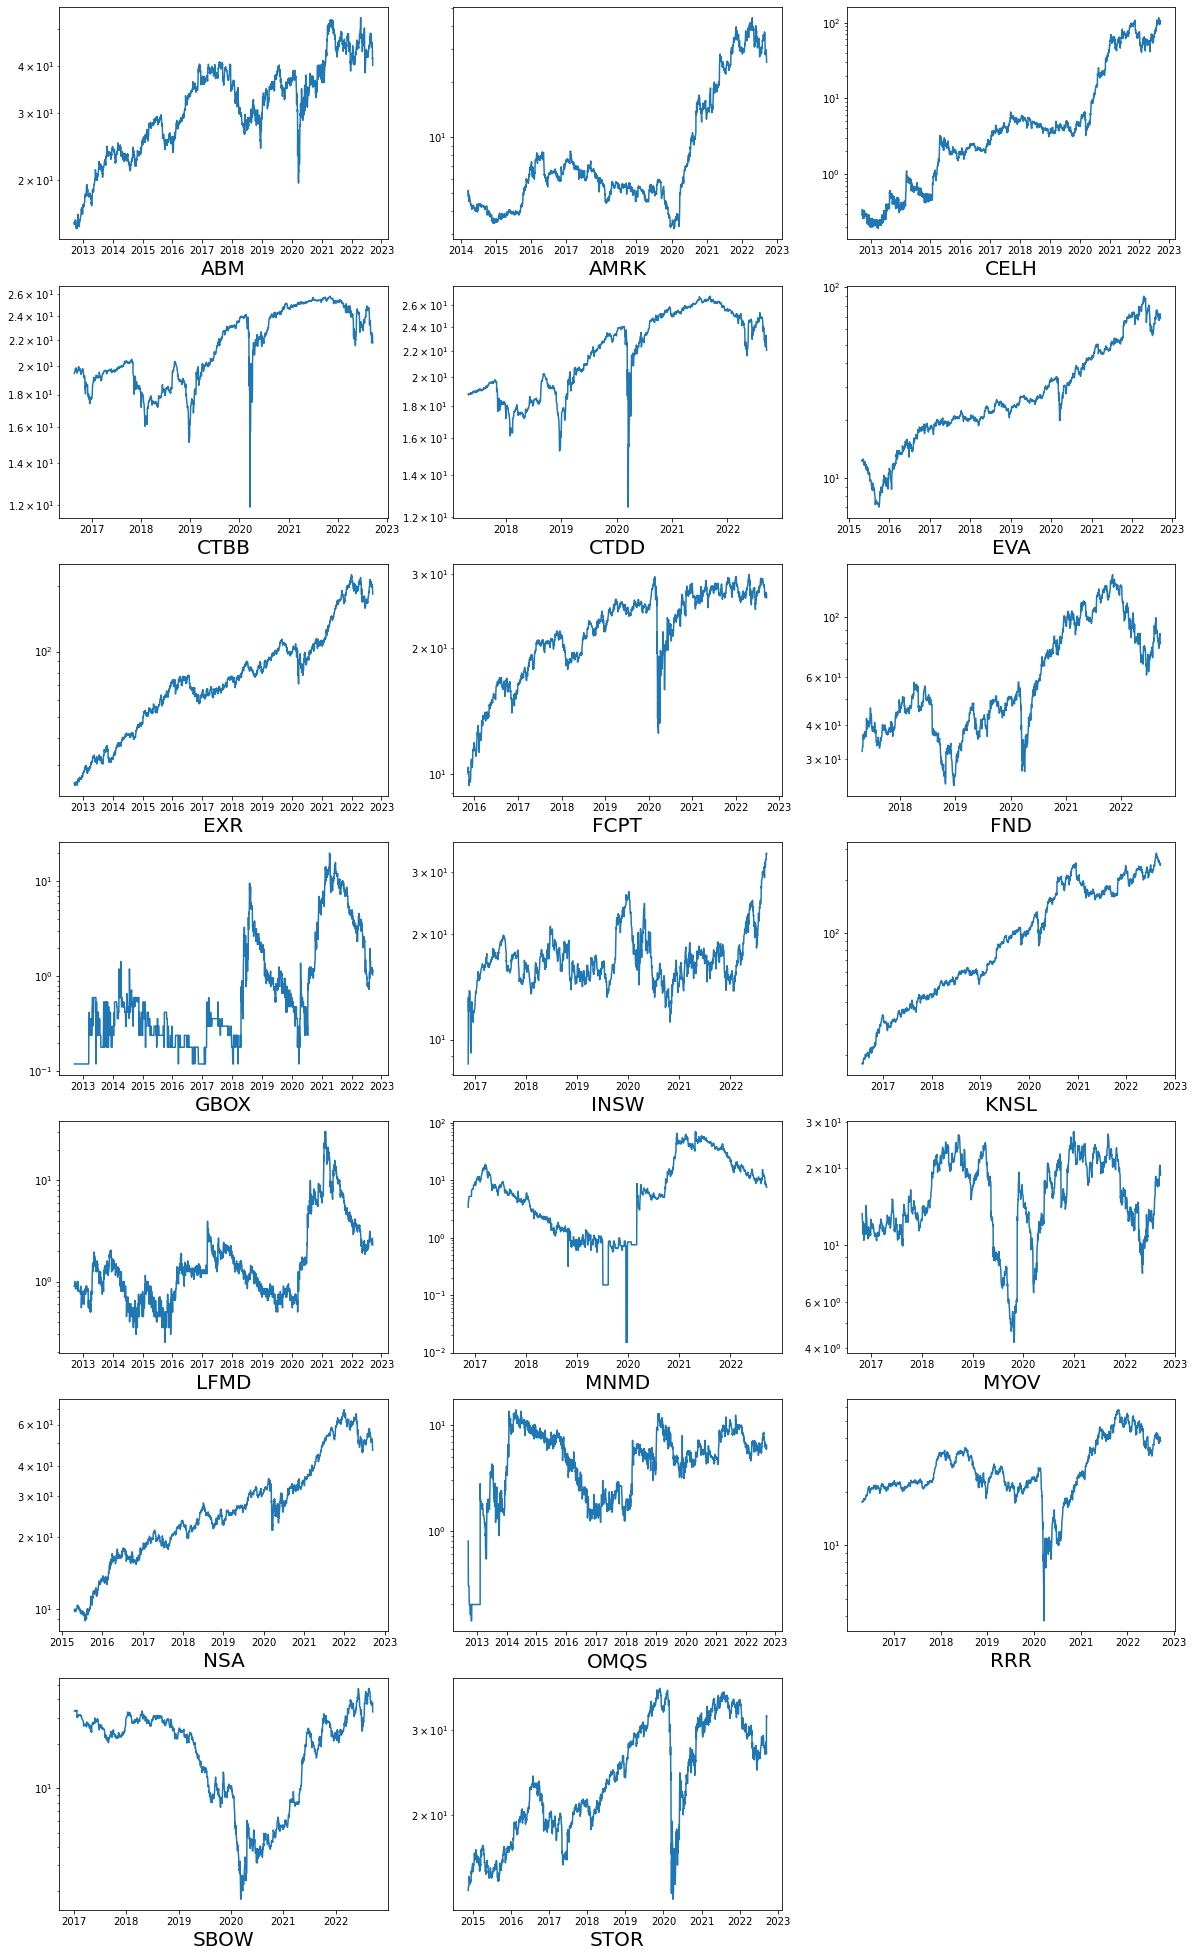

In [195]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

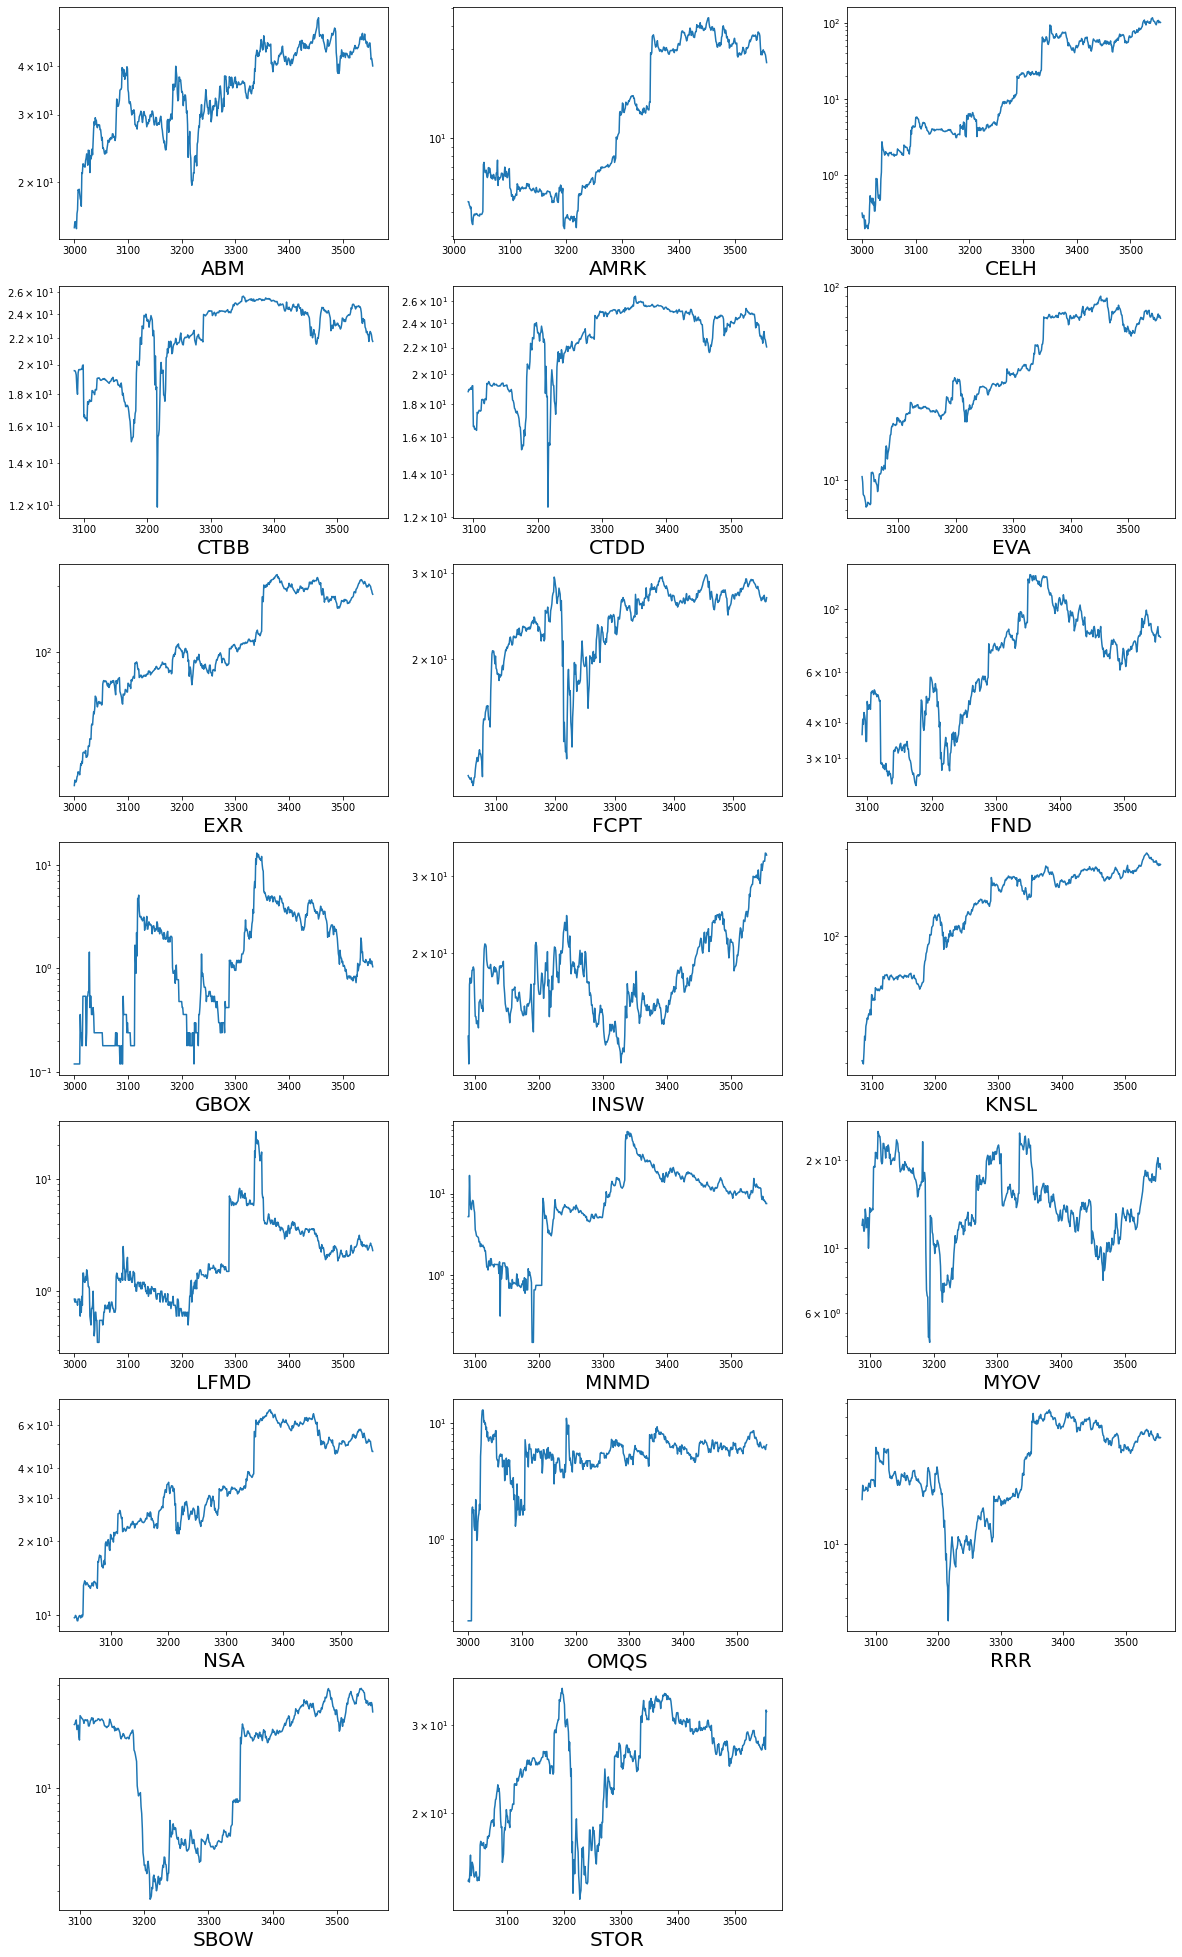

In [196]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data.loc[data.state == CURRENT_STATE, sym].to_numpy())
    plt.yscale('log')
    plt.xlabel(sym);

In [110]:
# Hedged best

hedged = (
    #df[['sharpe_3', 'sharpe_4', 'sharpe_5']]
    df[['sharpe_0', 'sharpe_1', 'sharpe_2']]
    .min(axis=1)
    .sort_values(ascending=False))
df.loc[hedged.index, :]

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5,weighted
GBOX,1.206515,1.030416,1.371489,0.888415,1.456559,1.295397,1.152314,1.206660
GME,0.755272,0.848177,1.054176,2.068633,-0.456684,-0.000728,0.888746,1.215867
EP,0.956185,0.995683,0.752510,1.308406,1.677714,0.104069,1.174442,0.912324
DLPN,0.588731,0.716551,0.787658,0.766054,0.746856,0.648702,0.032073,0.769116
OLB,0.462820,0.883949,0.683117,1.032472,1.073377,0.342769,0.698744,0.793154
...,...,...,...,...,...,...,...,...
SPLK,0.440629,-4.241017,0.749075,1.371040,0.607091,1.621604,2.656940,-0.124550
ENV,0.597177,-4.255549,0.561667,0.608444,2.982383,2.849967,2.778456,-0.392421
SVVC,-0.440643,-4.412356,0.125636,-1.745561,-0.464064,0.289914,1.995501,-1.156202
GWRE,0.432220,-4.561656,0.733734,1.382562,1.608043,1.448948,2.750029,-0.195578


In [36]:
#for stock in df_out.index:
#    if stock in big_df.index:
#        big_df.loc[stock, :] = big_df.loc[stock, :]
#    else:
#        big_df = pd.concat(
#            [big_df, pd.DataFrame(df_out.loc[stock, :]).T], axis=0)
#print(big_df.shape)
#big_df.head()

In [37]:
best_0 = best_n_by_state(df, 12, 0)
best_1 = best_n_by_state(df, 20, 1)
best_2 = best_n_by_state(df, 10, 2)
best_3 = best_n_by_state(df, 10, 3)

In [38]:
best_1 = [s for s in best_1 if s not in exclude]
df.loc[best_1, ['sharpe', 'sharpe_0', 'sharpe_1']]

,sharpe,sharpe_0,sharpe_1
PSA,0.652822,-1.594104,2.402697
EXR,0.995825,-1.301254,2.287625
LSI,0.787435,-1.369610,2.232905
TWNK,0.653646,-2.070600,2.190602
WCN,1.146046,-2.493781,2.187652
CUBE,0.789712,-1.406584,2.183502
EVA,0.899348,-1.673559,2.087028
REXR,0.907647,-2.413490,2.071381
IEA,0.450424,-1.727570,1.979441
TSLA,1.155725,-2.637910,1.925927
